# Import all the necessary packages

In [1]:
from sklearn.cross_validation import KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import Imputer, OneHotEncoder, LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score

from patsy import dmatrix
from scipy import stats

import statsmodels.api as sm
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

# Read the data from csv file

In [2]:
'''Import the train and test data set'''
data_train = pd.read_csv('train.csv')
data_train.shape

(21570, 292)

# Column name preprocessing to prevent R style crashes

In [3]:
def convert_column(data_train):
    data_train_columns = list(data_train.columns.values)
    for i in range(len(data_train_columns)):
        if '-' in data_train_columns[i]:
            data_train_columns[i] = data_train_columns[i].replace('-', '_')
    return data_train_columns

In [4]:
'''Some of the column names contain - signs which crashes the OLS algorithm'''
'''https://www.tutorialspoint.com/python/string_replace.htm'''
data_train_columns = convert_column(data_train)
data_train.columns = data_train_columns

X = data_train.iloc[:, 2:291]
y = data_train.iloc[:, 291]

# View how many data points are missing

In [5]:
'''This variable is used to check how much data is missing'''
missing_data_count = data_train.isnull().sum()
missing_data_count

id                                           0
timestamp                                    0
full_sq                                      0
life_sq                                   4539
floor                                      124
max_floor                                 6773
material                                  6773
build_year                                9621
num_room                                  6773
kitch_sq                                  6773
state                                     9600
product_type                                 0
sub_area                                     0
area_m                                       0
raion_popul                                  0
green_zone_part                              0
indust_part                                  0
children_preschool                           0
preschool_quota                           4720
preschool_education_centers_raion            0
children_school                              0
school_quota 

# Some label encoding and data filtering to convert non-numerical values to numerical values and to get rid of information that does not make sense.

In [6]:
def label_encoding(X):
    '''Label Encoding and mapping'''
    
    #sub_area encoding
    sub_area_le = LabelEncoder()
    X['sub_area'] = sub_area_le.fit_transform(X['sub_area'])
    
    #product_type encoding
    product_type_le = LabelEncoder()
    X['product_type'] = product_type_le.fit_transform(X['product_type'])
    
    #All the yes_no encoding
    yes_no_le = LabelEncoder()
    yes_no_list = ['thermal_power_plant_raion', 'incineration_raion', 'oil_chemistry_raion', 'radiation_raion', 
       'railroad_terminal_raion', 'big_market_raion', 'nuclear_reactor_raion', 'detention_facility_raion', 
       'water_1line', 'big_road1_1line', 'railroad_1line', 'culture_objects_top_25']
    for column in yes_no_list:
        X[column] = yes_no_le.fit_transform(X[column])
    
    #ecology mapping
    X['ecology'].unique()
    ecology_mapping = {'excellent' : 4, 'good' : 3, 'satisfactory' : 2, 'poor' : 1, 'no data' : np.nan}
    X['ecology'] = X['ecology'].map(ecology_mapping)
    
    encoder_dict = {'sub_area' : sub_area_le, 'product_type' : product_type_le, 'yes_no' : yes_no_le,
                    'ecology' : ecology_mapping}  
    return X, encoder_dict

def simple_filter(X):
    X.loc[ (X.build_year > 2015) | (X.build_year < 1600 ), 'build_year'] = np.nan
    X.loc[ (X.state > 4) | (X.state < 1), 'state'] = np.nan
    return X

In [7]:
'''Perform encoding and mapping'''
X, encoder_dict = label_encoding(data_train.iloc[:, 2:])

'''Drop all the data with nan terms'''
X_drop = X.dropna()
print(X_drop.shape)

'''Data description'''
data_describe = X_drop.describe()

'''build_year and state obviously need some modification'''
X_drop = simple_filter(X_drop)

(4218, 290)


C:\Users\cck3\Anaconda3\lib\site-packages\pandas\core\indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [8]:
X_drop.head()

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
5696,11,11.0,2.0,5.0,2.0,1907.0,1.0,12.0,3.0,0,...,339,135,26,133,207,1,89,161,10,2750000
5864,77,50.0,3.0,5.0,2.0,1957.0,3.0,8.0,2.0,0,...,214,85,21,48,89,1,54,146,12,11700000
5936,31,21.0,5.0,9.0,5.0,1962.0,1.0,5.0,3.0,0,...,99,43,8,17,41,1,18,93,5,6200000
5951,43,27.0,1.0,5.0,2.0,1960.0,2.0,5.0,2.0,0,...,24,4,0,20,40,0,10,101,7,5950000
5962,46,29.0,9.0,9.0,2.0,1969.0,2.0,5.0,3.0,0,...,7,4,0,9,15,0,0,42,3,5900000


# Drop the filtered nan values and reset the index

### Reference: https://stackoverflow.com/questions/20490274/how-to-reset-index-in-a-pandas-data-frame

In [9]:
'''Once again drop the nan terms that were filtered, and look at the data 
description to make sure the filtration has been carried out properly'''
'''Reference: https://stackoverflow.com/questions/20490274/how-to-reset-index-in-a-pandas-data-frame'''
X_drop = X_drop.dropna().reset_index(drop = True)
data_describe = X_drop.describe()
X_drop.head()

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,11,11.0,2.0,5.0,2.0,1907.0,1.0,12.0,3.0,0,...,339,135,26,133,207,1,89,161,10,2750000
1,77,50.0,3.0,5.0,2.0,1957.0,3.0,8.0,2.0,0,...,214,85,21,48,89,1,54,146,12,11700000
2,31,21.0,5.0,9.0,5.0,1962.0,1.0,5.0,3.0,0,...,99,43,8,17,41,1,18,93,5,6200000
3,43,27.0,1.0,5.0,2.0,1960.0,2.0,5.0,2.0,0,...,24,4,0,20,40,0,10,101,7,5950000
4,46,29.0,9.0,9.0,2.0,1969.0,2.0,5.0,3.0,0,...,7,4,0,9,15,0,0,42,3,5900000


In [10]:
X_drop.tail()

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
4105,38,19.0,7.0,17.0,1.0,2006.0,1.0,7.0,3.0,0,...,26,12,0,8,23,1,4,67,2,6800000
4106,54,32.0,8.0,16.0,1.0,1979.0,2.0,9.0,2.0,0,...,8,0,0,6,25,0,1,32,8,9500000
4107,56,29.0,13.0,14.0,1.0,2001.0,2.0,11.0,3.0,0,...,14,2,0,13,12,0,1,53,6,12000000
4108,64,32.0,5.0,15.0,1.0,2003.0,2.0,11.0,2.0,0,...,22,1,1,6,31,1,4,65,7,13500000
4109,43,28.0,1.0,9.0,1.0,1968.0,2.0,6.0,2.0,0,...,5,2,0,7,16,0,9,54,10,5600000


In [11]:
X_drop.shape

(4110, 290)

# Check if anymore strings are left
### Reference: https://stackoverflow.com/questions/21771133/finding-non-numeric-rows-in-dataframe-in-pandas

In [12]:
print(X_drop[~X_drop.applymap(np.isreal).all(1)])

Empty DataFrame
Columns: [full_sq, life_sq, floor, max_floor, material, build_year, num_room, kitch_sq, state, product_type, sub_area, area_m, raion_popul, green_zone_part, indust_part, children_preschool, preschool_quota, preschool_education_centers_raion, children_school, school_quota, school_education_centers_raion, school_education_centers_top_20_raion, hospital_beds_raion, healthcare_centers_raion, university_top_20_raion, sport_objects_raion, additional_education_raion, culture_objects_top_25, culture_objects_top_25_raion, shopping_centers_raion, office_raion, thermal_power_plant_raion, incineration_raion, oil_chemistry_raion, radiation_raion, railroad_terminal_raion, big_market_raion, nuclear_reactor_raion, detention_facility_raion, full_all, male_f, female_f, young_all, young_male, young_female, work_all, work_male, work_female, ekder_all, ekder_male, ekder_female, 0_6_all, 0_6_male, 0_6_female, 7_14_all, 7_14_male, 7_14_female, 0_17_all, 0_17_male, 0_17_female, 16_29_all, 16_2

# Separate data into different types and re-partitioning the dataframe

In [13]:
#Nominal category values
nom_categorical_list =['material', 'product_type', 'sub_area', 'ID_metro', 'ID_railroad_station_walk',
                   'ID_railroad_station_avto', 'ID_big_road1', 
                   'ID_big_road2', 'ID_railroad_terminal', 'ID_bus_terminal',  
                   'thermal_power_plant_raion', 'incineration_raion', 'oil_chemistry_raion', 'radiation_raion', 
                   'railroad_terminal_raion', 'big_market_raion', 'nuclear_reactor_raion', 
                   'detention_facility_raion', 'water_1line', 'big_road1_1line', 'railroad_1line', 
                   'culture_objects_top_25']

#Ordinal category values
ord_categorical_list = ['state', 'ecology']

#target/y values
target = 'price_doc'

#Numerical values 
filter_list = nom_categorical_list + ord_categorical_list + [target]
numeric_list = list(X_drop.columns)
for item in filter_list:
    numeric_list.remove(item)
    
    
'''Filter out categorical values that I will not be using'''
nom_categorical_list =['material', 'product_type', 'thermal_power_plant_raion', 'incineration_raion', 'oil_chemistry_raion', 
                       'radiation_raion', 'railroad_terminal_raion', 'big_market_raion', 'nuclear_reactor_raion', 
                       'detention_facility_raion', 'water_1line', 'big_road1_1line', 'railroad_1line', 'culture_objects_top_25']
    
'''Re-partitioning the DataFrame numeric -> ord_cat -> nom_cat -> target'''
X_drop = pd.concat([X_drop[numeric_list], X_drop[ord_categorical_list], 
                    X_drop[nom_categorical_list], X_drop[target]], axis = 1)
X_drop.tail()

,full_sq,life_sq,floor,max_floor,build_year,num_room,kitch_sq,area_m,raion_popul,green_zone_part,...,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,water_1line,big_road1_1line,railroad_1line,culture_objects_top_25,price_doc
4105,38,19.0,7.0,17.0,2006.0,1.0,7.0,1.752651e+07,118843,0.133373,...,0,0,0,0,0,0,0,0,0,6800000
4106,54,32.0,8.0,16.0,1979.0,2.0,9.0,2.481385e+07,174831,0.683844,...,1,0,0,0,0,0,0,0,0,9500000
4107,56,29.0,13.0,14.0,2001.0,2.0,11.0,9.249237e+06,156377,0.374068,...,0,0,0,0,0,0,0,0,0,12000000
4108,64,32.0,5.0,15.0,2003.0,2.0,11.0,6.050065e+06,78616,0.167526,...,1,0,0,0,0,0,0,0,0,13500000
4109,43,28.0,1.0,9.0,1968.0,2.0,6.0,4.395333e+06,94561,0.063755,...,1,0,0,0,0,0,0,0,0,5600000


In [14]:
X_drop.shape

(4110, 282)

# Standardize the numerical and ordinal category data

### References on how to handle ordinal category features:
### https://learnandteachstatistics.wordpress.com/2013/07/08/ordinal/
### https://www.ma.utexas.edu/users/mks/statmistakes/ordinal.html
### https://www3.nd.edu/~rwilliam/stats3/OrdinalIndependent.pdf

### Text Referece:
### Python Machine Learning 2nd Edition, Sebastian Raschka & Vahid Mirjalili

In [15]:
'''Apply scaling to numeric value and declare a variable for the new standardized matrix'''
sc = StandardScaler()
X_drop_sc = X_drop[:]
X_drop_sc[numeric_list] = sc.fit_transform(X_drop_sc[numeric_list])

# VIF analysis for variables with high correlation

### Reference: http://support.minitab.com/en-us/minitab/17/topic-library/modeling-statistics/regression-and-correlation/model-assumptions/what-is-a-variance-inflation-factor-vif/

In [16]:
def VIF_analysis(X):
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif["features"] = X.columns
    return vif

In [17]:
vif_metro = VIF_analysis(X_drop_sc[['metro_min_avto', 'metro_km_avto', 'metro_km_walk', 'metro_min_walk']])
vif_railroad = VIF_analysis(X_drop_sc[['railroad_station_avto_min', 'railroad_station_avto_km', 
                                       'railroad_station_walk_min', 'railroad_station_walk_km']])
vif_population = VIF_analysis(X_drop_sc[['raion_popul', 'children_school', 'children_preschool', 'full_all', 'male_f', 
                           'female_f', 'young_all', 'young_male', 'young_female', 'work_all', 'work_male', 
                           'work_female', 'ekder_all', 'ekder_male', 'ekder_female', '0_6_all', '0_6_male', 
                           '0_6_female', '7_14_all', '7_14_male', '7_14_female', '0_17_all', '0_17_male', 
                           '0_17_female', '16_29_all', '16_29_male', '16_29_female', '0_13_all', '0_13_male',
                           '0_13_female']])

In [18]:
vif_metro.head()

,VIF Factor,features
0,7.736992,metro_min_avto
1,13.625832,metro_km_avto
2,inf,metro_km_walk
3,inf,metro_min_walk


In [19]:
vif_railroad.head()

,VIF Factor,features
0,12.742023,railroad_station_avto_min
1,21.461014,railroad_station_avto_km
2,inf,railroad_station_walk_min
3,inf,railroad_station_walk_km


In [20]:
vif_population = vif_population.sort_values('VIF Factor')
vif_population

,VIF Factor,features
8,5.316867e+03,young_female
11,5.990659e+03,work_female
9,8.699701e+03,work_all
1,1.042878e+04,children_school
0,1.228560e+05,raion_popul
6,1.994247e+05,young_all
4,9.720893e+05,male_f
7,2.841439e+06,young_male
25,inf,16_29_male
19,inf,7_14_male


In [21]:
'''Based on VIF analysis following features will be dropped'''
vif_delete_list = list(vif_metro.loc[vif_metro['VIF Factor'] > 10, 'features']) + \
                  list(vif_population.loc[vif_population['VIF Factor'] > 10**7 , 'features']) + \
                  list(vif_railroad.loc[vif_railroad['VIF Factor'] > 20, 'features'])

In [22]:
print("{} variables have been filtered through VIF method".format(len(vif_delete_list)))
print()
print(vif_delete_list)

28 variables have been filtered through VIF method

['metro_km_avto', 'metro_km_walk', 'metro_min_walk', '16_29_male', '7_14_male', '16_29_female', '16_29_all', '0_13_all', '0_17_female', '0_17_male', '0_17_all', '7_14_female', '7_14_all', 'ekder_female', '0_6_male', '0_6_all', '0_13_male', 'ekder_male', 'ekder_all', 'work_male', 'female_f', 'full_all', 'children_preschool', '0_6_female', '0_13_female', 'railroad_station_avto_km', 'railroad_station_walk_min', 'railroad_station_walk_km']


# Drop the vif_delete_list elements from the numeric list

### Reference: https://stackoverflow.com/questions/28538536/deleting-multiple-columns-in-pandas

In [23]:
X_drop_sc.drop(vif_delete_list, axis = 1, inplace = True)
numeric_list_vif = numeric_list[:]
for item in vif_delete_list:
    numeric_list_vif.remove(item)
    
X_drop.drop(vif_delete_list, axis = 1, inplace = True)

In [24]:
X_drop.shape

(4110, 254)

# Compile the variables names into string format that can be fed into R-style dmatrix encoding

In [25]:
'''Compile a string that will be fed into sm.OLS.from_formula'''
'''Handling numeric and ord categorical information. Add this too!'''
numeric_ord_cat_OLS_string = " + ".join(numeric_list_vif + ord_categorical_list)

'''Handling the nominal categorical information with C()'''
category_OLS_string = "C(material)"

'''yes no categorical values don't need to be separately encoded'''
yes_no_list = ['thermal_power_plant_raion', 'incineration_raion', 'oil_chemistry_raion', 'radiation_raion', 
                   'railroad_terminal_raion', 'big_market_raion', 'nuclear_reactor_raion', 
                   'detention_facility_raion', 'water_1line', 'big_road1_1line', 'railroad_1line', 
                   'culture_objects_top_25', 'product_type']
yes_no_OLS_string = " + ".join(yes_no_list)

'''This is the total string'''
OLS_string = numeric_ord_cat_OLS_string + " + " + category_OLS_string + " + " + yes_no_OLS_string

In [26]:
print(OLS_string)

full_sq + life_sq + floor + max_floor + build_year + num_room + kitch_sq + area_m + raion_popul + green_zone_part + indust_part + preschool_quota + preschool_education_centers_raion + children_school + school_quota + school_education_centers_raion + school_education_centers_top_20_raion + hospital_beds_raion + healthcare_centers_raion + university_top_20_raion + sport_objects_raion + additional_education_raion + culture_objects_top_25_raion + shopping_centers_raion + office_raion + male_f + young_all + young_male + young_female + work_all + work_female + raion_build_count_with_material_info + build_count_block + build_count_wood + build_count_frame + build_count_brick + build_count_monolith + build_count_panel + build_count_foam + build_count_slag + build_count_mix + raion_build_count_with_builddate_info + build_count_before_1920 + build_count_1921_1945 + build_count_1946_1970 + build_count_1971_1995 + build_count_after_1995 + metro_min_avto + kindergarten_km + school_km + park_km + gr

In [27]:
'''Create a dmatrix for encoding and extract the column variables so they can
be used to access features with low p values'''
'''https://stackoverflow.com/questions/23560104/fetching-names-from-designmatrix-in-patsy'''
dfX = dmatrix(OLS_string, data = X_drop)
dfX_columns = dfX.design_info.column_names
dfX = pd.DataFrame(dfX, columns = dfX_columns)

dfY = pd.DataFrame(X_drop_sc['price_doc'])

dfX.tail()

,Intercept,C(material)[T.2.0],C(material)[T.4.0],C(material)[T.5.0],C(material)[T.6.0],full_sq,life_sq,floor,max_floor,build_year,...,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,water_1line,big_road1_1line,railroad_1line,culture_objects_top_25,product_type
4105,1.0,0.0,0.0,0.0,0.0,38.0,19.0,7.0,17.0,2006.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4106,1.0,0.0,0.0,0.0,0.0,54.0,32.0,8.0,16.0,1979.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4107,1.0,0.0,0.0,0.0,0.0,56.0,29.0,13.0,14.0,2001.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4108,1.0,0.0,0.0,0.0,0.0,64.0,32.0,5.0,15.0,2003.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4109,1.0,0.0,0.0,0.0,0.0,43.0,28.0,1.0,9.0,1968.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
dfX.shape

(4110, 257)

# Multiple OLS run to filter out high p-value coefficients

In [29]:
model = sm.OLS(dfY, dfX)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:              price_doc   R-squared:                       0.637
Model:                            OLS   Adj. R-squared:                  0.614
Method:                 Least Squares   F-statistic:                     27.69
Date:                Tue, 24 Oct 2017   Prob (F-statistic):               0.00
Time:                        23:54:28   Log-Likelihood:                -68064.
No. Observations:                4110   AIC:                         1.366e+05
Df Residuals:                    3864   BIC:                         1.382e+05
Df Model:                         245                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------------------

In [30]:
def p_value_extract(result, confidence):
    '''https://stackoverflow.com/questions/37787698/how-to-sort-pandas-dataframe-from-one-column'''
    p_values = pd.DataFrame(result.pvalues)
    p_values.columns = ['p_value']
    p_values['p_value'] = p_values[p_values.p_value < confidence]
    p_values = p_values.dropna().sort_values('p_value')
    return p_values

In [31]:
p = p_value_extract(result, 0.05)
extracted_feature = list(p.index.values)
print('The number of extracted features is: ', len(extracted_feature))
dfX_extract = dfX.loc[:, extracted_feature]
dfX_extract.tail()

The number of extracted features is:  41


,full_sq,state,leisure_count_1500,cafe_count_1500_price_4000,leisure_count_2000,kitch_sq,floor,life_sq,cafe_count_1500_price_high,thermal_power_plant_km,...,industrial_km,cafe_count_2000_price_1000,young_male,office_count_3000,cafe_count_5000_price_4000,ice_rink_km,cafe_count_1500_price_1000,big_church_count_1500,C(material)[T.6.0],office_count_500
4105,38.0,3.0,0.0,0.0,0.0,7.0,7.0,19.0,0.0,1.425857,...,0.675151,2.0,8287.0,12.0,12.0,6.034370,2.0,0.0,0.0,0.0
4106,54.0,2.0,0.0,0.0,0.0,9.0,8.0,32.0,0.0,6.655360,...,1.824382,4.0,12083.0,1.0,0.0,2.412572,4.0,2.0,0.0,0.0
4107,56.0,3.0,1.0,0.0,1.0,11.0,13.0,29.0,0.0,5.721404,...,1.646417,6.0,12039.0,6.0,2.0,7.261430,3.0,1.0,0.0,0.0
4108,64.0,2.0,0.0,0.0,2.0,11.0,5.0,32.0,0.0,6.417997,...,2.397723,23.0,4815.0,15.0,1.0,2.630674,13.0,0.0,0.0,0.0
4109,43.0,2.0,4.0,0.0,5.0,6.0,1.0,28.0,0.0,5.239948,...,0.455194,11.0,6724.0,6.0,2.0,1.684764,9.0,2.0,0.0,0.0


In [32]:
#This runs without returing an error
dfX_extract['Intercept']

0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
5       1.0
6       1.0
7       1.0
8       1.0
9       1.0
10      1.0
11      1.0
12      1.0
13      1.0
14      1.0
15      1.0
16      1.0
17      1.0
18      1.0
19      1.0
20      1.0
21      1.0
22      1.0
23      1.0
24      1.0
25      1.0
26      1.0
27      1.0
28      1.0
29      1.0
       ... 
4080    1.0
4081    1.0
4082    1.0
4083    1.0
4084    1.0
4085    1.0
4086    1.0
4087    1.0
4088    1.0
4089    1.0
4090    1.0
4091    1.0
4092    1.0
4093    1.0
4094    1.0
4095    1.0
4096    1.0
4097    1.0
4098    1.0
4099    1.0
4100    1.0
4101    1.0
4102    1.0
4103    1.0
4104    1.0
4105    1.0
4106    1.0
4107    1.0
4108    1.0
4109    1.0
Name: Intercept, dtype: float64

In [33]:
dfX2 = dfX_extract
dfX2.tail()

,full_sq,state,leisure_count_1500,cafe_count_1500_price_4000,leisure_count_2000,kitch_sq,floor,life_sq,cafe_count_1500_price_high,thermal_power_plant_km,...,industrial_km,cafe_count_2000_price_1000,young_male,office_count_3000,cafe_count_5000_price_4000,ice_rink_km,cafe_count_1500_price_1000,big_church_count_1500,C(material)[T.6.0],office_count_500
4105,38.0,3.0,0.0,0.0,0.0,7.0,7.0,19.0,0.0,1.425857,...,0.675151,2.0,8287.0,12.0,12.0,6.034370,2.0,0.0,0.0,0.0
4106,54.0,2.0,0.0,0.0,0.0,9.0,8.0,32.0,0.0,6.655360,...,1.824382,4.0,12083.0,1.0,0.0,2.412572,4.0,2.0,0.0,0.0
4107,56.0,3.0,1.0,0.0,1.0,11.0,13.0,29.0,0.0,5.721404,...,1.646417,6.0,12039.0,6.0,2.0,7.261430,3.0,1.0,0.0,0.0
4108,64.0,2.0,0.0,0.0,2.0,11.0,5.0,32.0,0.0,6.417997,...,2.397723,23.0,4815.0,15.0,1.0,2.630674,13.0,0.0,0.0,0.0
4109,43.0,2.0,4.0,0.0,5.0,6.0,1.0,28.0,0.0,5.239948,...,0.455194,11.0,6724.0,6.0,2.0,1.684764,9.0,2.0,0.0,0.0


In [34]:
dfX2.shape

(4110, 41)

In [35]:
model2 = sm.OLS(dfY, dfX2)
result2 = model2.fit()
print(result2.summary())

                            OLS Regression Results                            
Dep. Variable:              price_doc   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.591
Method:                 Least Squares   F-statistic:                     149.7
Date:                Tue, 24 Oct 2017   Prob (F-statistic):               0.00
Time:                        23:54:28   Log-Likelihood:                -68287.
No. Observations:                4110   AIC:                         1.367e+05
Df Residuals:                    4069   BIC:                         1.369e+05
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------
full_sq             

In [36]:
p2 = p_value_extract(result2, 0.05)
extracted_feature2 = list(p2.index.values)
print('The number of extracted features is: ', len(extracted_feature2))
dfX_extract2 = dfX2.loc[:, extracted_feature2]
dfX_extract2.tail()

The number of extracted features is:  31


,full_sq,leisure_count_2000,leisure_count_1500,state,cafe_count_5000_price_4000,industrial_km,life_sq,kitch_sq,cafe_count_1500_price_high,hospital_beds_raion,...,cafe_count_2000_price_1000,cafe_sum_500_min_price_avg,cafe_avg_price_500,cafe_sum_500_max_price_avg,office_count_3000,big_church_count_1500,thermal_power_plant_km,C(material)[T.6.0],cafe_count_1000_price_1000,max_floor
4105,38.0,0.0,0.0,3.0,12.0,0.675151,19.0,7.0,0.0,990.0,...,2.0,500.0,750.0,1000.0,12.0,0.0,1.425857,0.0,1.0,17.0
4106,54.0,0.0,0.0,2.0,0.0,1.824382,32.0,9.0,0.0,2300.0,...,4.0,500.0,750.0,1000.0,1.0,2.0,6.655360,0.0,3.0,16.0
4107,56.0,1.0,1.0,3.0,2.0,1.646417,29.0,11.0,0.0,1145.0,...,6.0,400.0,575.0,750.0,6.0,1.0,5.721404,0.0,1.0,14.0
4108,64.0,2.0,0.0,2.0,1.0,2.397723,32.0,11.0,0.0,3300.0,...,23.0,1000.0,1250.0,1500.0,15.0,0.0,6.417997,0.0,6.0,15.0
4109,43.0,5.0,4.0,2.0,2.0,0.455194,28.0,6.0,0.0,1015.0,...,11.0,400.0,575.0,750.0,6.0,2.0,5.239948,0.0,6.0,9.0


In [37]:
#This code should spit out an error since Intercept was filtered with p-value test.
#dfX_extract2['Intercept']

In [38]:
#Not sure why but constants are added at some random location.....
dfX3 = sm.add_constant(dfX_extract2)
dfX3.tail()

,const,full_sq,leisure_count_2000,leisure_count_1500,state,cafe_count_5000_price_4000,industrial_km,life_sq,kitch_sq,cafe_count_1500_price_high,...,cafe_count_2000_price_1000,cafe_sum_500_min_price_avg,cafe_avg_price_500,cafe_sum_500_max_price_avg,office_count_3000,big_church_count_1500,thermal_power_plant_km,C(material)[T.6.0],cafe_count_1000_price_1000,max_floor
4105,1,38.0,0.0,0.0,3.0,12.0,0.675151,19.0,7.0,0.0,...,2.0,500.0,750.0,1000.0,12.0,0.0,1.425857,0.0,1.0,17.0
4106,1,54.0,0.0,0.0,2.0,0.0,1.824382,32.0,9.0,0.0,...,4.0,500.0,750.0,1000.0,1.0,2.0,6.655360,0.0,3.0,16.0
4107,1,56.0,1.0,1.0,3.0,2.0,1.646417,29.0,11.0,0.0,...,6.0,400.0,575.0,750.0,6.0,1.0,5.721404,0.0,1.0,14.0
4108,1,64.0,2.0,0.0,2.0,1.0,2.397723,32.0,11.0,0.0,...,23.0,1000.0,1250.0,1500.0,15.0,0.0,6.417997,0.0,6.0,15.0
4109,1,43.0,5.0,4.0,2.0,2.0,0.455194,28.0,6.0,0.0,...,11.0,400.0,575.0,750.0,6.0,2.0,5.239948,0.0,6.0,9.0


In [39]:
dfX3.shape

(4110, 32)

In [40]:
model3 = sm.OLS(dfY, dfX3)
result3 = model3.fit()
print(result3.summary())

                            OLS Regression Results                            
Dep. Variable:              price_doc   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.591
Method:                 Least Squares   F-statistic:                     192.9
Date:                Tue, 24 Oct 2017   Prob (F-statistic):               0.00
Time:                        23:54:28   Log-Likelihood:                -68292.
No. Observations:                4110   AIC:                         1.366e+05
Df Residuals:                    4078   BIC:                         1.368e+05
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------
const               

In [41]:
p3 = p_value_extract(result3, 0.05)
extracted_feature3 = list(p3.index.values)
print('The number of extracted features is: ', len(extracted_feature3))
dfX_extract3 = dfX3.loc[:, extracted_feature3]
dfX_extract3.tail()

The number of extracted features is:  30


,full_sq,leisure_count_2000,leisure_count_1500,const,state,cafe_count_5000_price_4000,industrial_km,life_sq,product_type,cafe_count_1500_price_high,...,cafe_count_2000_price_1000,leisure_count_500,C(material)[T.4.0],cafe_sum_500_min_price_avg,cafe_avg_price_500,cafe_sum_500_max_price_avg,big_church_count_1500,C(material)[T.6.0],cafe_count_1000_price_1000,thermal_power_plant_km
4105,38.0,0.0,0.0,1,3.0,12.0,0.675151,19.0,0.0,0.0,...,2.0,0.0,0.0,500.0,750.0,1000.0,0.0,0.0,1.0,1.425857
4106,54.0,0.0,0.0,1,2.0,0.0,1.824382,32.0,0.0,0.0,...,4.0,0.0,0.0,500.0,750.0,1000.0,2.0,0.0,3.0,6.655360
4107,56.0,1.0,1.0,1,3.0,2.0,1.646417,29.0,0.0,0.0,...,6.0,0.0,0.0,400.0,575.0,750.0,1.0,0.0,1.0,5.721404
4108,64.0,2.0,0.0,1,2.0,1.0,2.397723,32.0,0.0,0.0,...,23.0,0.0,0.0,1000.0,1250.0,1500.0,0.0,0.0,6.0,6.417997
4109,43.0,5.0,4.0,1,2.0,2.0,0.455194,28.0,0.0,0.0,...,11.0,4.0,0.0,400.0,575.0,750.0,2.0,0.0,6.0,5.239948


In [42]:
#Not sure why but constants are added at some random location.....
dfX4 = sm.add_constant(dfX_extract3)
dfX4.tail()

,full_sq,leisure_count_2000,leisure_count_1500,const,state,cafe_count_5000_price_4000,industrial_km,life_sq,product_type,cafe_count_1500_price_high,...,cafe_count_2000_price_1000,leisure_count_500,C(material)[T.4.0],cafe_sum_500_min_price_avg,cafe_avg_price_500,cafe_sum_500_max_price_avg,big_church_count_1500,C(material)[T.6.0],cafe_count_1000_price_1000,thermal_power_plant_km
4105,38.0,0.0,0.0,1,3.0,12.0,0.675151,19.0,0.0,0.0,...,2.0,0.0,0.0,500.0,750.0,1000.0,0.0,0.0,1.0,1.425857
4106,54.0,0.0,0.0,1,2.0,0.0,1.824382,32.0,0.0,0.0,...,4.0,0.0,0.0,500.0,750.0,1000.0,2.0,0.0,3.0,6.655360
4107,56.0,1.0,1.0,1,3.0,2.0,1.646417,29.0,0.0,0.0,...,6.0,0.0,0.0,400.0,575.0,750.0,1.0,0.0,1.0,5.721404
4108,64.0,2.0,0.0,1,2.0,1.0,2.397723,32.0,0.0,0.0,...,23.0,0.0,0.0,1000.0,1250.0,1500.0,0.0,0.0,6.0,6.417997
4109,43.0,5.0,4.0,1,2.0,2.0,0.455194,28.0,0.0,0.0,...,11.0,4.0,0.0,400.0,575.0,750.0,2.0,0.0,6.0,5.239948


In [43]:
dfX4.shape

(4110, 30)

In [44]:
model4 = sm.OLS(dfY, dfX4)
result4 = model4.fit()
print(result4.summary())

                            OLS Regression Results                            
Dep. Variable:              price_doc   R-squared:                       0.594
Model:                            OLS   Adj. R-squared:                  0.591
Method:                 Least Squares   F-statistic:                     205.8
Date:                Tue, 24 Oct 2017   Prob (F-statistic):               0.00
Time:                        23:54:28   Log-Likelihood:                -68295.
No. Observations:                4110   AIC:                         1.366e+05
Df Residuals:                    4080   BIC:                         1.368e+05
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------
full_sq             

In [45]:
OLS_feature_extracted = list(dfX4.columns.values)
print(OLS_feature_extracted)
print()
print("{} features survived the consecutive OLS p-value test filtration".format(len(OLS_feature_extracted)))

['full_sq', 'leisure_count_2000', 'leisure_count_1500', 'const', 'state', 'cafe_count_5000_price_4000', 'industrial_km', 'life_sq', 'product_type', 'cafe_count_1500_price_high', 'cafe_count_1500_price_4000', 'kitch_sq', 'ice_rink_km', 'floor', 'hospital_beds_raion', 'railroad_1line', 'metro_min_avto', 'church_synagogue_km', 'office_sqm_1500', 'C(material)[T.2.0]', 'cafe_count_2000_price_1000', 'leisure_count_500', 'C(material)[T.4.0]', 'cafe_sum_500_min_price_avg', 'cafe_avg_price_500', 'cafe_sum_500_max_price_avg', 'big_church_count_1500', 'C(material)[T.6.0]', 'cafe_count_1000_price_1000', 'thermal_power_plant_km']

30 features survived the consecutive OLS p-value test filtration


# Outlier detection/elimination

In [46]:
def outlier_crusher(result):
    influence = result.get_influence()
    cooks_d2, pvals = influence.cooks_distance
    fox_cr = 4 / (len(dfY) - dfX2.shape[1] - 1)
    idx = np.where(cooks_d2 > fox_cr)[0]
    return idx

In [47]:
idx = outlier_crusher(result4)
print(idx)
print()
print('There are {} outliers according to Fox criteria.'.format(len(idx)))

[   0   22   24   29   49   55   65   82   84   90  108  140  169  215  218
  237  240  242  245  262  272  284  290  295  337  361  371  373  376  382
  406  411  433  440  445  484  539  548  558  564  585  598  602  603  615
  657  669  713  716  718  749  761  816  858  879  991 1008 1012 1025 1146
 1152 1170 1177 1221 1271 1279 1282 1326 1329 1347 1349 1387 1402 1407 1421
 1441 1449 1451 1455 1464 1467 1479 1488 1496 1502 1506 1524 1534 1537 1554
 1566 1568 1581 1590 1614 1619 1627 1633 1637 1647 1663 1681 1684 1700 1755
 1764 1769 1777 1801 1805 1809 1811 1832 1843 1845 1864 1871 1897 1902 1909
 1926 1933 1986 1995 2007 2018 2029 2032 2041 2049 2060 2070 2087 2143 2150
 2157 2158 2162 2166 2256 2257 2305 2328 2330 2384 2404 2407 2414 2424 2443
 2454 2481 2505 2519 2520 2544 2574 2587 2604 2607 2633 2660 2666 2684 2689
 2690 2697 2707 2724 2725 2730 2737 2758 2778 2807 2817 2830 2841 2869 2904
 2923 2930 2934 2981 3006 3017 3025 3057 3092 3111 3126 3132 3138 3145 3157
 3172 3200 3

In [48]:
dfX4_idx = dfX4.drop(idx)
dfY_idx = dfY.drop(idx)

print(dfX4_idx.shape)
print(dfY_idx.shape)

(3836, 30)
(3836, 1)


# Run an OLS model after outlier extraction

In [49]:
dfX4_idx_c = sm.add_constant(dfX4_idx)

model_idx_c = sm.OLS(dfY_idx, dfX4_idx_c)
result_idx_c = model_idx_c.fit()
print(result_idx_c.summary())

                            OLS Regression Results                            
Dep. Variable:              price_doc   R-squared:                       0.663
Model:                            OLS   Adj. R-squared:                  0.660
Method:                 Least Squares   F-statistic:                     257.7
Date:                Tue, 24 Oct 2017   Prob (F-statistic):               0.00
Time:                        23:54:28   Log-Likelihood:                -61940.
No. Observations:                3836   AIC:                         1.239e+05
Df Residuals:                    3806   BIC:                         1.241e+05
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------
full_sq             

In [50]:
del dfX4_idx_c['railroad_1line']
OLS_feature_extracted.remove('railroad_1line')

In [51]:
dfX4_idx_c.shape

(3836, 29)

In [52]:
print(OLS_feature_extracted)

['full_sq', 'leisure_count_2000', 'leisure_count_1500', 'const', 'state', 'cafe_count_5000_price_4000', 'industrial_km', 'life_sq', 'product_type', 'cafe_count_1500_price_high', 'cafe_count_1500_price_4000', 'kitch_sq', 'ice_rink_km', 'floor', 'hospital_beds_raion', 'metro_min_avto', 'church_synagogue_km', 'office_sqm_1500', 'C(material)[T.2.0]', 'cafe_count_2000_price_1000', 'leisure_count_500', 'C(material)[T.4.0]', 'cafe_sum_500_min_price_avg', 'cafe_avg_price_500', 'cafe_sum_500_max_price_avg', 'big_church_count_1500', 'C(material)[T.6.0]', 'cafe_count_1000_price_1000', 'thermal_power_plant_km']


# Apply feature scaling and train_test_split

### Reference: https://stats.stackexchange.com/questions/160902/is-it-possible-for-test-error-to-be-lower-than-training-error

In [53]:
def num_cat_divider(X, feature):
    X_numeric, X_cat = [], []
    for item in feature:
        if item == 'state':
            X_cat.append(item)
        elif len(X[item].unique()) > 2:
            X_numeric.append(item)
        else:
            X_cat.append(item)
    return X[X_numeric], X[X_cat]

In [54]:
'''Now apply train_test analysis on OLS using exracted features after scaling
the necessary features. The split should be around 7:3 ratio, and make sure to
include stratified option'''

'''dfX2 is now our non-scaled feature matrix with dfY being the dependent variable
vector. First repartition dfX2 into numerical and categorical parts'''
dfX4_train, dfX4_test, dfY_train, dfY_test = train_test_split(dfX4_idx_c, dfY_idx, test_size = 0.2, random_state = 0)


'''
#Split into numerical anc categorical parts'''
dfX4_train_numeric, dfX4_train_cat = num_cat_divider(dfX4_train, OLS_feature_extracted)
dfX4_test_numeric, dfX4_test_cat = num_cat_divider(dfX4_test, OLS_feature_extracted)
#Index saved for later proprocessing
dfX4_train_index = list(dfX4_train_numeric.index.values)
dfX4_test_index = list(dfX4_test_numeric.index.values)


sc_dfx4 = StandardScaler()
dfX4_train_numeric_sc = pd.DataFrame(sc_dfx4.fit_transform(dfX4_train_numeric), 
                                     columns = dfX4_train_numeric.columns.values, index=dfX4_train_index)
dfX4_test_numeric_sc = pd.DataFrame(sc_dfx4.transform(dfX4_test_numeric), 
                                    columns = dfX4_test_numeric.columns.values, index=dfX4_test_index)

dfX4_train_sc = pd.concat([dfX4_train_numeric_sc, dfX4_train_cat], axis = 1)
dfX4_test_sc = pd.concat([dfX4_test_numeric_sc, dfX4_test_cat], axis = 1)

print(dfX4_train_sc.shape)
print(dfY_train.shape)

(3068, 29)
(3068, 1)


In [55]:
dfX4_train_cat.head()

,const,state,product_type,C(material)[T.2.0],C(material)[T.4.0],C(material)[T.6.0]
329,1,2.0,0.0,0.0,0.0,0.0
852,1,4.0,0.0,0.0,0.0,0.0
2944,1,2.0,0.0,0.0,0.0,0.0
3030,1,2.0,0.0,1.0,0.0,0.0
960,1,2.0,0.0,0.0,0.0,0.0


In [56]:
print(dfX4_test_sc.shape)
print(dfY_test.shape)

(768, 29)
(768, 1)


In [57]:
dfX4_train_sc.tail()

,full_sq,leisure_count_2000,leisure_count_1500,cafe_count_5000_price_4000,industrial_km,life_sq,cafe_count_1500_price_high,cafe_count_1500_price_4000,kitch_sq,ice_rink_km,...,cafe_sum_500_max_price_avg,big_church_count_1500,cafe_count_1000_price_1000,thermal_power_plant_km,const,state,product_type,C(material)[T.2.0],C(material)[T.4.0],C(material)[T.6.0]
890,-0.843408,-0.385576,-0.400627,-0.454525,-0.511395,-0.853073,-0.256130,-0.273399,0.310839,-1.204989,...,-1.461908,-0.276086,-0.457690,0.561432,1,3.0,0.0,0.0,0.0,0.0
3485,2.804227,-0.385576,-0.400627,-0.360222,-1.298757,2.827358,-0.256130,-0.273399,0.695688,1.902959,...,-0.436759,-0.453660,-0.457690,-0.702147,1,4.0,0.0,1.0,0.0,0.0
1758,1.737995,-0.227997,-0.082448,-0.517393,2.255831,1.502403,-0.256130,-0.273399,1.465386,-0.227895,...,-0.539274,-0.276086,0.622827,0.707523,1,3.0,0.0,0.0,0.0,0.0
2781,-0.731173,0.402320,0.235730,2.248813,-0.151135,-0.632247,1.976277,0.618360,-0.074009,-0.247567,...,-0.095035,0.079063,0.502770,1.765468,1,2.0,0.0,0.0,0.0,0.0
2912,-0.282233,-0.385576,-0.400627,-0.485959,-0.231730,-0.190595,-0.256130,-0.273399,-0.843707,0.238246,...,-0.436759,-0.276086,-0.577747,-1.142018,1,3.0,0.0,0.0,0.0,0.0


# Run an OLS model with the scaled training dataset

In [58]:
'''OLS run for train and test runs respectively'''
model_train = sm.OLS(dfY_train, dfX4_train_sc)
result_train = model_train.fit()
print(result_train.summary())

                            OLS Regression Results                            
Dep. Variable:              price_doc   R-squared:                       0.659
Model:                            OLS   Adj. R-squared:                  0.655
Method:                 Least Squares   F-statistic:                     209.4
Date:                Tue, 24 Oct 2017   Prob (F-statistic):               0.00
Time:                        23:54:29   Log-Likelihood:                -49556.
No. Observations:                3068   AIC:                         9.917e+04
Df Residuals:                    3039   BIC:                         9.935e+04
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------
full_sq             

In [59]:
#Additional independent variable filtered out due to high p-values
del dfX4_train_sc['life_sq']
del dfX4_train_sc['cafe_sum_500_min_price_avg']
del dfX4_train_sc['cafe_avg_price_500']
del dfX4_train_sc['cafe_sum_500_max_price_avg']
del dfX4_train_sc['cafe_count_1000_price_1000']
del dfX4_train_sc['thermal_power_plant_km']

del dfX4_test_sc['life_sq']
del dfX4_test_sc['cafe_sum_500_min_price_avg']
del dfX4_test_sc['cafe_avg_price_500']
del dfX4_test_sc['cafe_sum_500_max_price_avg']
del dfX4_test_sc['cafe_count_1000_price_1000']
del dfX4_test_sc['thermal_power_plant_km']

In [60]:
dfX4_train_sc.shape

(3068, 23)

In [61]:
dfX4_test_sc.shape

(768, 23)

In [62]:
'''OLS run for train and test runs respectively'''
model_train2 = sm.OLS(dfY_train, dfX4_train_sc)
result_train2 = model_train2.fit()
print(result_train2.summary())

                            OLS Regression Results                            
Dep. Variable:              price_doc   R-squared:                       0.657
Model:                            OLS   Adj. R-squared:                  0.655
Method:                 Least Squares   F-statistic:                     265.4
Date:                Tue, 24 Oct 2017   Prob (F-statistic):               0.00
Time:                        23:54:29   Log-Likelihood:                -49562.
No. Observations:                3068   AIC:                         9.917e+04
Df Residuals:                    3045   BIC:                         9.931e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------
full_sq             

# Residual plot, Partial Regression plot, and CCPR

### Reference: Reference: http://www.statsmodels.org/dev/examples/notebooks/generated/regression_plots.html

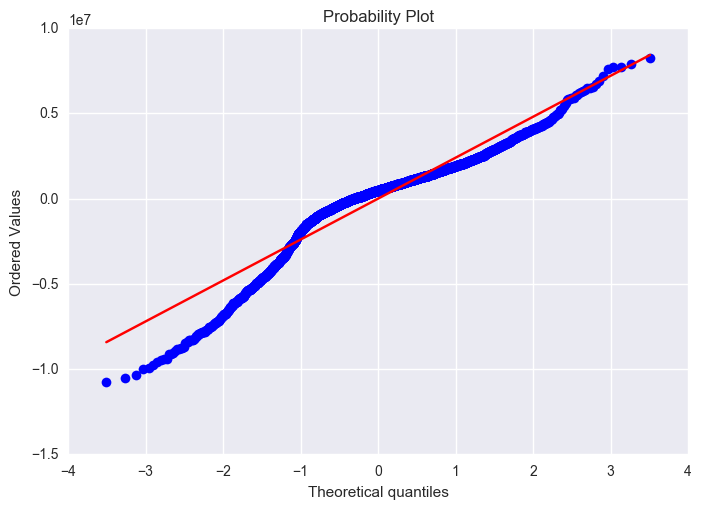

In [63]:
stats.probplot(result_train2.resid, plot=plt)
plt.show()

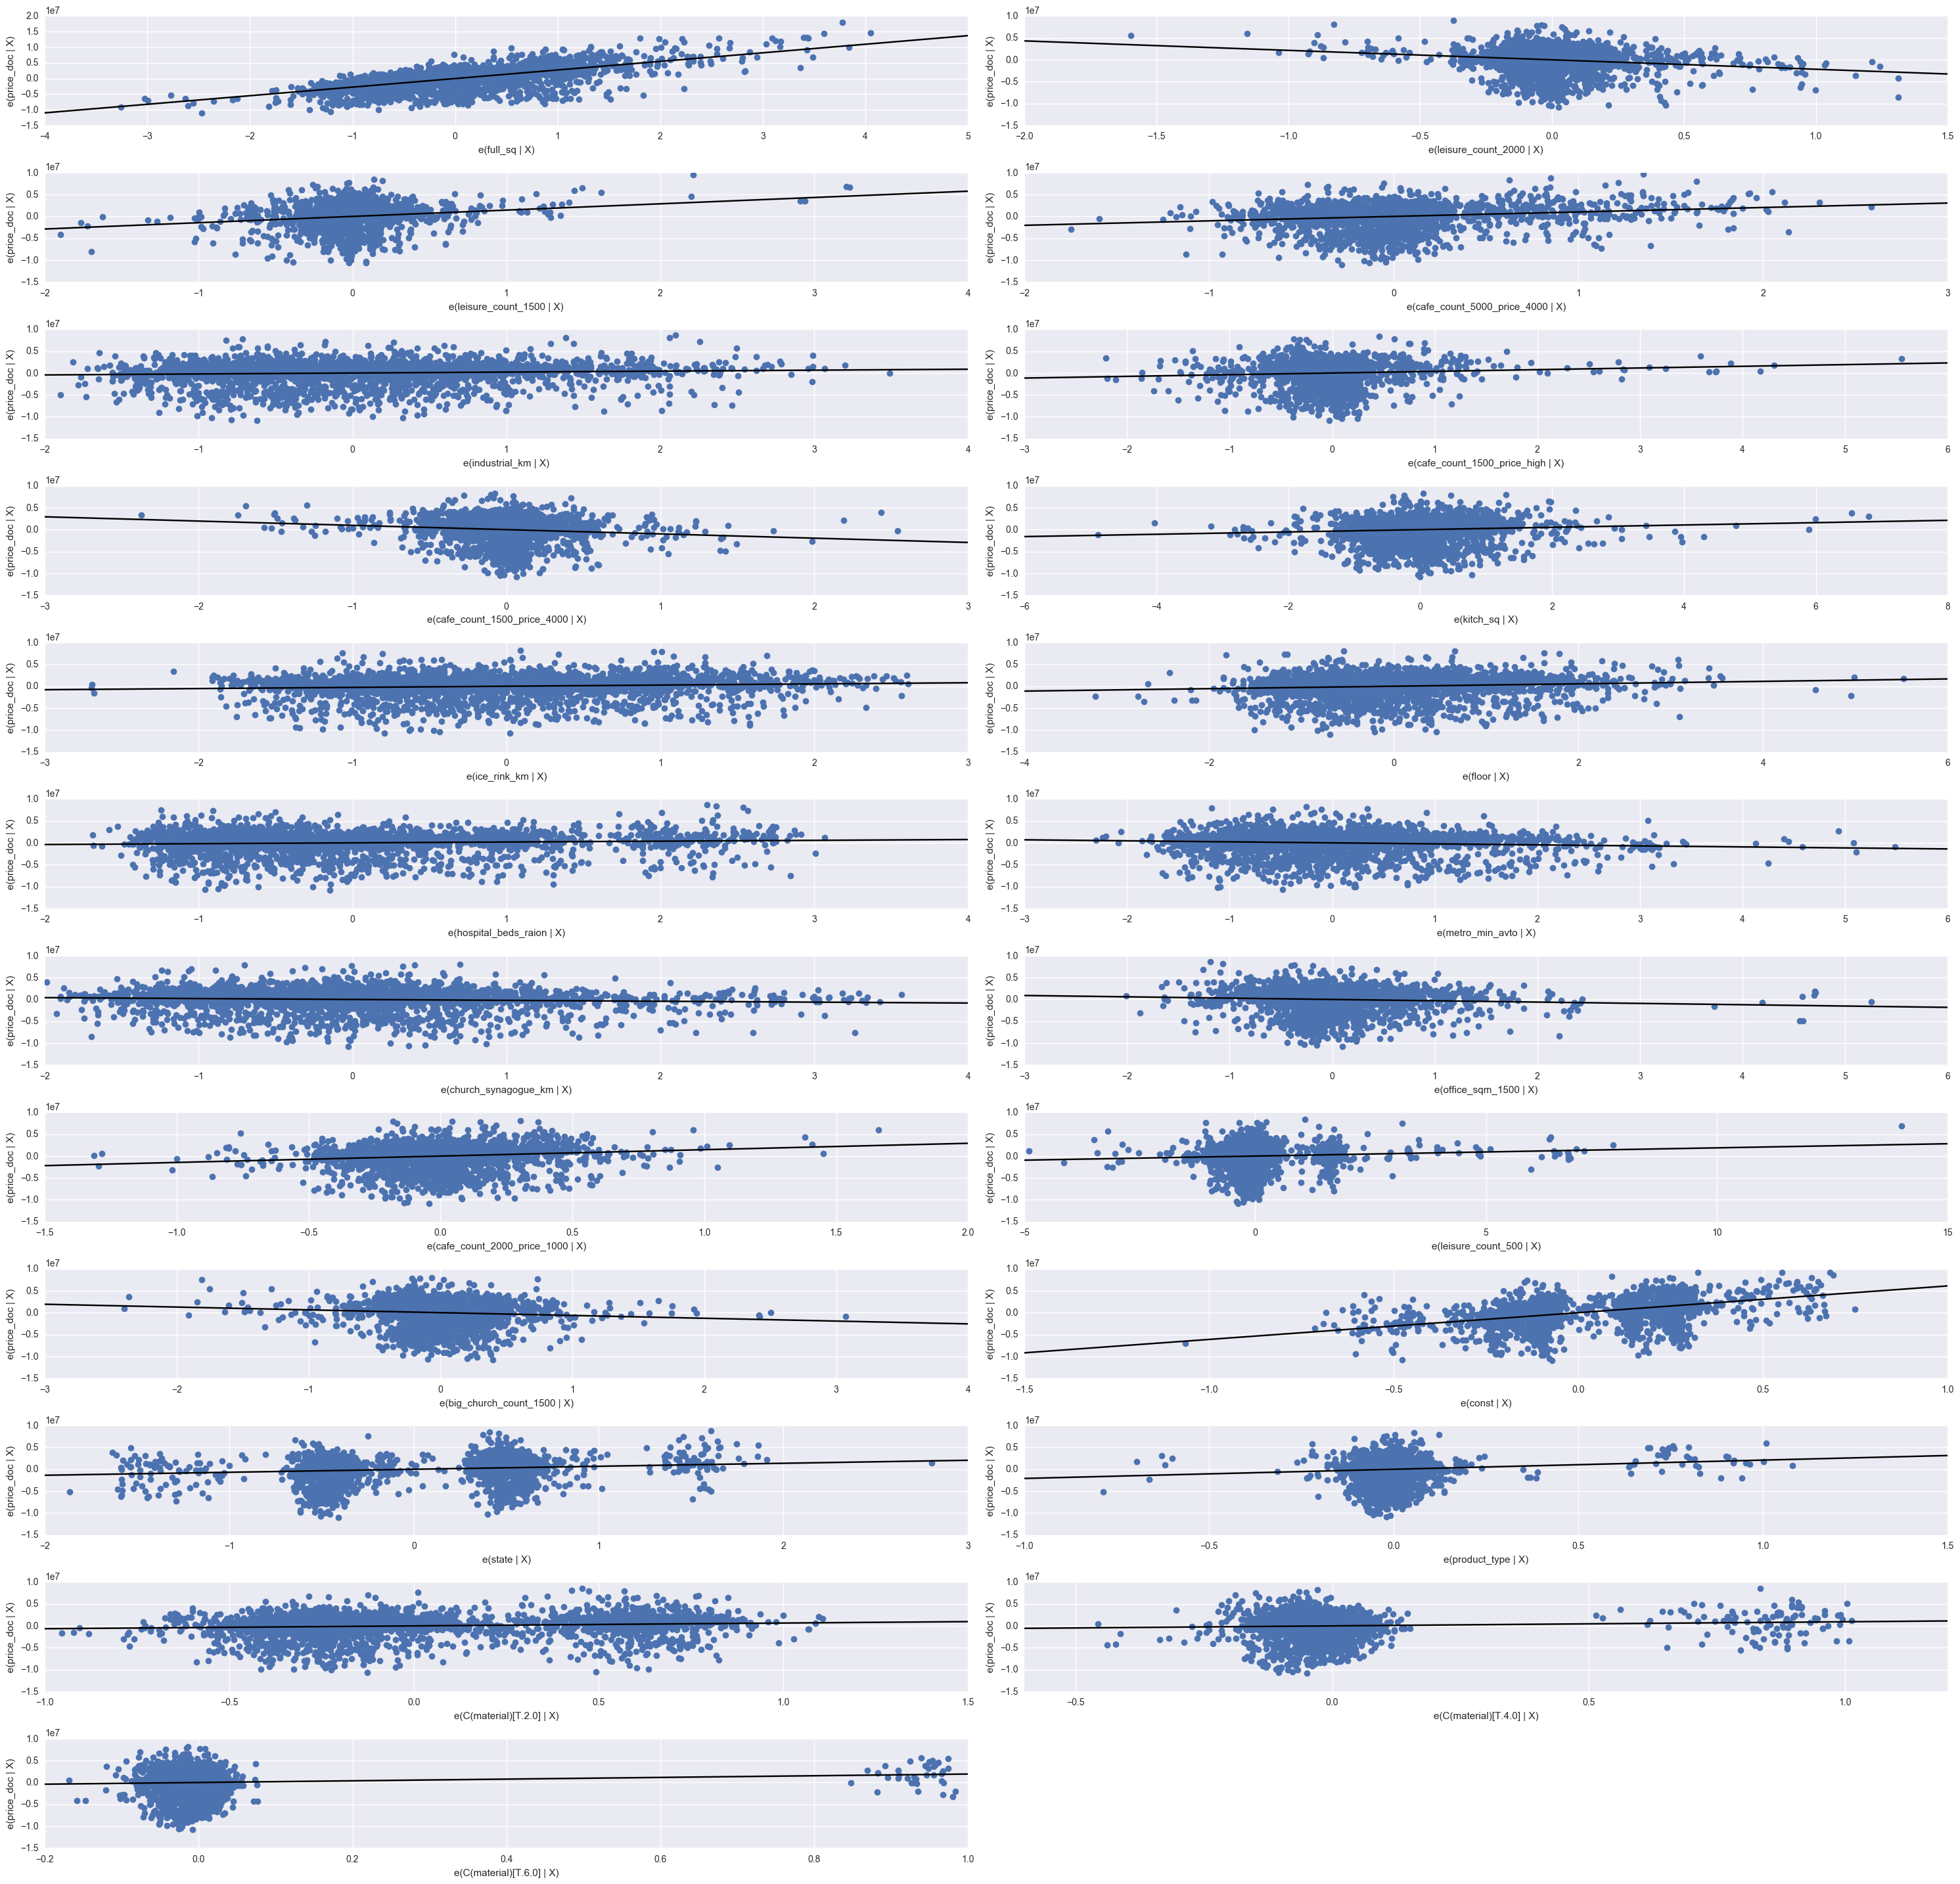

In [64]:
#Partial regression graph
fig = plt.figure(figsize = (30,30))
sm.graphics.plot_partregress_grid(result_train2, fig=fig)
fig.suptitle("")
plt.show()

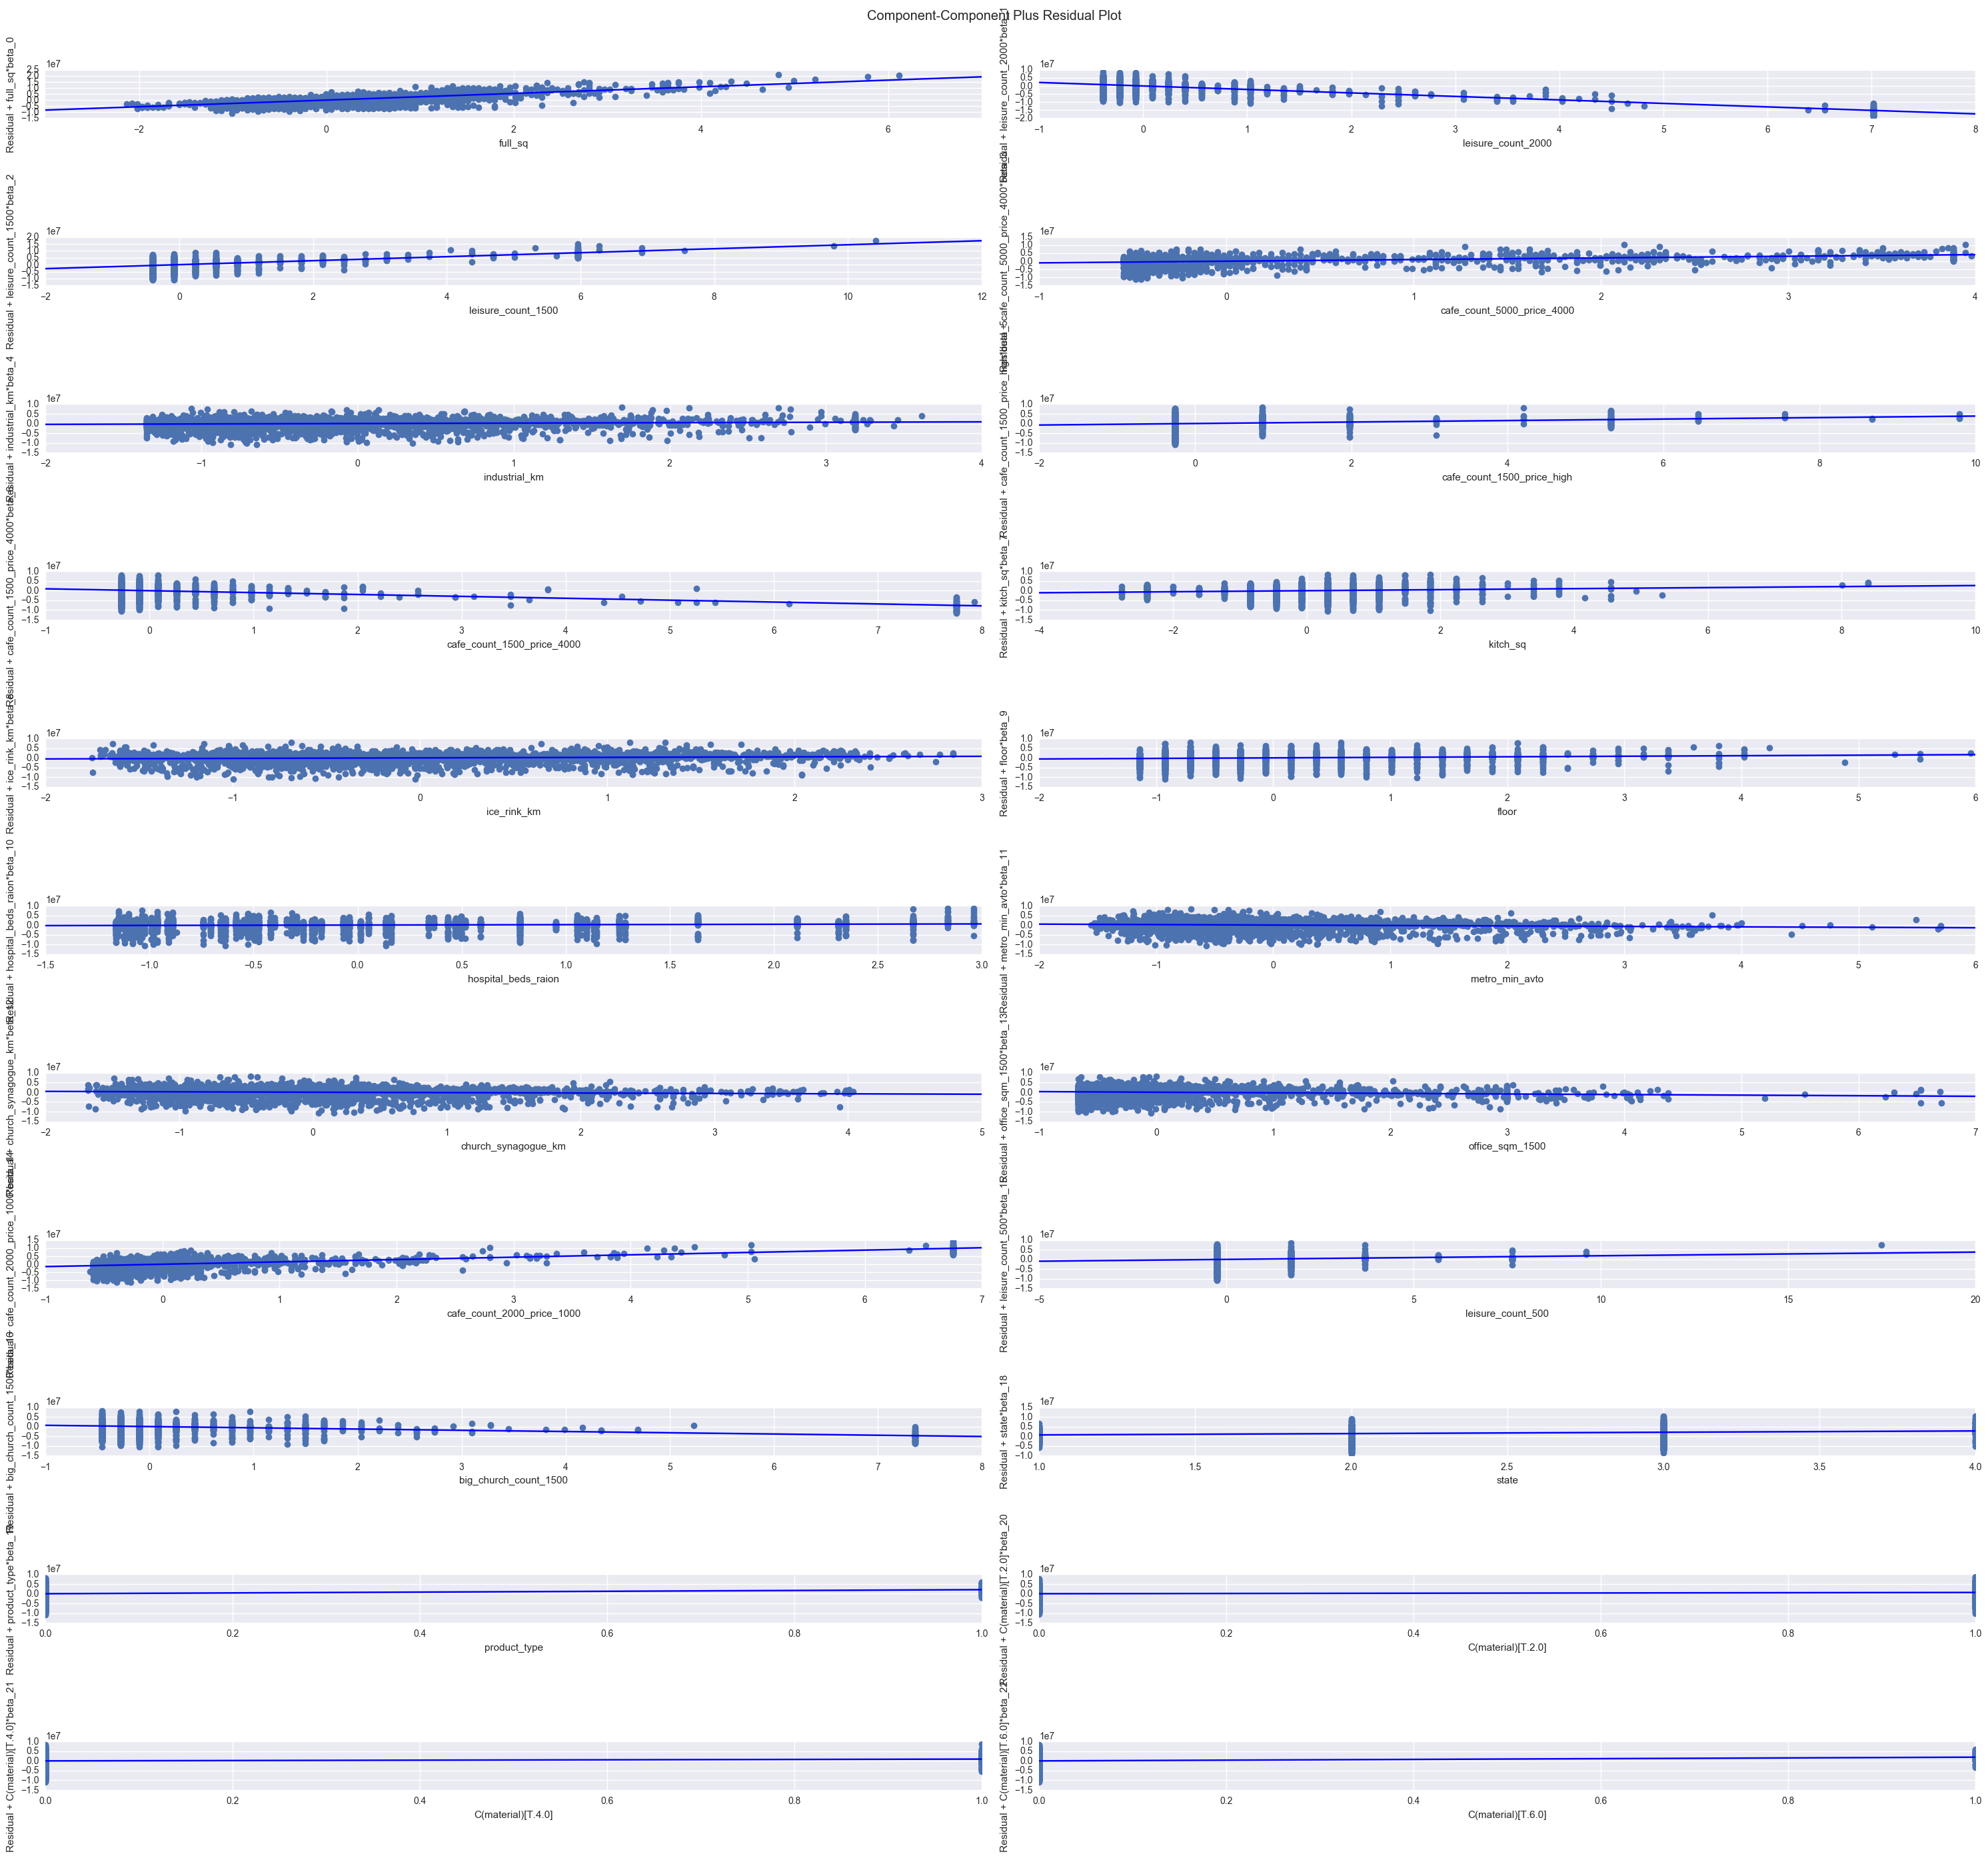

In [65]:
#CCPR plot
fig2 = plt.figure(figsize = (30,30))
sm.graphics.plot_ccpr_grid(result_train2, fig=fig2)
fig.suptitle("")
plt.show()

# Train/Test accuracy comparison to observe overfitting

### Reference: https://stats.stackexchange.com/questions/7948/when-is-it-ok-to-remove-the-intercept-in-a-linear-regression-model

In [66]:
train_pred = result_train2.predict(dfX4_train_sc)
train_r2_sk = r2_score(dfY_train, train_pred)
train_r2_sk

0.65722322512588471

In [67]:
test_pred = result_train2.predict(dfX4_test_sc)
test_r2_sk = r2_score(dfY_test, test_pred)
test_r2_sk

0.66989600815183281

In [68]:
dfY_train.shape

(3068, 1)

## In the current model, the test accuracy was ever so slightly higher than the training accuracy, but the difference appears pretty trivial and most likely due to the randomness in the train_test_split method. But, once again, we will run cross validation hyperparameter optimization just to make sure.

# Apply regularization with kfold cross vadliation

In [69]:
target = dfY_train.values.reshape(len(dfY_train), )

L1_wt_dict = {'Ridge':0, 'Elastic':0.5, 'Lasso':1}
alpha_list = [0.001, 0.01, 0.1, 1, 5]

r2_dict = {}
for r_type, L1_weight in L1_wt_dict.items():
    for alpha in alpha_list:
        kf = KFold(n = dfY_train.shape[0], n_folds = 10, random_state = 0) 
        r2_list = []
        for train, test in kf:
            model_kf = sm.OLS(dfY_train.iloc[train, :], dfX4_train_sc.iloc[train, :])
            result_kf = model_kf.fit_regularized(alpha = alpha, L1_wt = L1_weight)

            test_pred_kf = result_kf.predict(dfX4_train_sc.iloc[test, :])
            test_kf_r2 = r2_score(dfY_train.iloc[test, :], test_pred_kf)
            r2_list.append(test_kf_r2)
        r2_mean = np.array([r2_list]).mean()
        r2_dict[r_type + ',' + str(alpha)] = r2_mean
r2_dict

{'Elastic,0.001': 0.64391858299398785,
 'Elastic,0.01': 0.64252007801499678,
 'Elastic,0.1': 0.60965095459224339,
 'Elastic,1': 0.46753372590642861,
 'Elastic,5': 0.039384217833124492,
 'Lasso,0.001': 0.64394733965922391,
 'Lasso,0.01': 0.64394733913159108,
 'Lasso,0.1': 0.64394733385509095,
 'Lasso,1': 0.64394728107282295,
 'Lasso,5': 0.64394704610512576,
 'Ridge,0.001': 0.64385732183191113,
 'Ridge,0.01': 0.63959938898459434,
 'Ridge,0.1': 0.58144974620755741,
 'Ridge,1': 0.35580249683669479,
 'Ridge,5': -0.42696568583352779}

### Just as with the case of confidence level 1%, Elastic net and Ridge regularizations' accuracy drops around regularization strength of 0.1. On the other hand, Lasso seems most stable with higher R squared value (although not by much). 

### We will use Lasso with strength of 0.1 again

# Run the model with Lasso regularization at strength of 0.1

In [70]:
'''Regularized OLS run to prevent overfitting'''
model_train_lasso = sm.OLS(dfY_train, dfX4_train_sc)
result_train_lasso = model_train_lasso.fit_regularized(alpha = 0.1, L1_weight = 1)
print(result_train_lasso.summary())

                            OLS Regression Results                            
Dep. Variable:              price_doc   R-squared:                       0.657
Model:                            OLS   Adj. R-squared:                  0.655
Method:                 Least Squares   F-statistic:                     265.4
Date:                Tue, 24 Oct 2017   Prob (F-statistic):               0.00
Time:                        23:55:23   Log-Likelihood:                -49562.
No. Observations:                3068   AIC:                         9.917e+04
Df Residuals:                    3045   BIC:                         9.931e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------
full_sq             

In [71]:
train_pred = result_train_lasso.predict(dfX4_train_sc)
train_r2_sk = r2_score(dfY_train, train_pred)
train_r2_sk

0.6572232251257033

In [72]:
test_pred = result_train_lasso.predict(dfX4_test_sc)
test_r2_sk = r2_score(dfY_test, test_pred)
test_r2_sk

0.6698960571681376

# Compute the RMSE values using the final Lasso model and train/test dataset. Obviously, we'll have to try and apply this metric to the entire dataset after we've filled the missing data with imputation.

In [73]:
from sklearn.metrics import mean_squared_error

rmse_train = mean_squared_error(train_pred, dfY_train)**(1/2)
rmse_test = mean_squared_error(test_pred, dfY_test)**(1/2)

print('RMSE for training set is {}, RMSE for test set is {}'.format(rmse_train, rmse_test))

RMSE for training set is 2509811.9905945743, RMSE for test set is 2466855.956200637


In [74]:
def rmsle(predicted,real):
    sum=0.0
    for x in range(len(predicted)):
        p = np.log(predicted[x]+1)
        r = np.log(real[x]+1)
        sum = sum + (p - r)**2
    return (sum/len(predicted))**0.5

In [75]:
rmsle_train = rmsle(train_pred, np.array(dfY_train))
rmsle_test = rmsle(test_pred, np.array(dfY_test))

print('RMSLE for the training set is {}, RMSLE for the test set is {}'.format(rmsle_train, rmsle_test))

RMSLE for the training set is [ 0.52848159], RMSLE for the test set is [ 0.49552079]


# Summary

### Best Result: 
5% Confidence Interval P-value filtration with consecutive OLS runs

R^2_adj = **0.66** for the training set  **0.67** for the test set

Total number of variables = 23 (including the intercept)

### Things we wanted to try out but didn't have the chance to:
1) Feature Selection -> SBS (Sequential Backward Selection), Random Forest, Lasso Regularization

2) Polynomial Terms

3) Find out why natural log approach didn't work for confidence interval of 1%

4) Maybe we could've tried out confidence interval 10% with consecutive OLS run filtration